### TCR-seq analysis by scirpy

In [ ]:
!pip --python `which python` install scikit-misc harmonypy leidenalg parasail

In [ ]:
#!pip --python `which python` install git+https://github.com/scverse/scirpy.git@main # Version 0.19
#!pip --python `which python` install scikit-misc harmonypy leidenalg
import scanpy as sc
import scirpy as ir
import numpy as np
#import muon as mu
import anndata

sc.set_figure_params(dpi=300, dpi_save=300, figsize=(4,4))
sc.settings.figdir = '/data/project/AI4Omic/MASLD/results/scRNA/VDJ'

/home/bailab/miniconda3/envs/scirpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
adata_gex = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/preprocessing/adata_29samples.h5ad')

In [ ]:
# T subset
adata_tcr = adata_gex[adata_gex.obs.cell_type_lvl1.isin(['Resident NK', 'Circulating NK/NKT', 'T cell'])].copy()
adata_tcr.X = adata_tcr.layers['counts'].copy()

import harmonypy
import scanpy.external as sce
# Normalization
sc.pp.normalize_total(adata_tcr)
sc.pp.log1p(adata_tcr)

# Batch effect Correction
sc.pp.highly_variable_genes(adata_tcr, n_top_genes=4000, batch_key="orig.ident", flavor='seurat_v3')
sc.pp.pca(adata_tcr)
sce.pp.harmony_integrate(adata_tcr, 'orig.ident', max_iter_harmony=30)
sc.pp.neighbors(adata_tcr, n_neighbors=30, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata_tcr, min_dist=1.0)
sc.tl.leiden(adata_tcr, resolution=1.5, flavor='igraph', n_iterations=2)

In [32]:
# Batch effect Correction
import harmonypy
import scanpy.external as sce
sc.pp.highly_variable_genes(adata_tcr, n_top_genes=4000, batch_key="orig.ident", flavor='seurat_v3')
sc.pp.pca(adata_tcr)
sce.pp.harmony_integrate(adata_tcr, 'orig.ident', max_iter_harmony=30)
sc.pp.neighbors(adata_tcr, n_neighbors=10, n_pcs=20, use_rep='X_pca_harmony')
sc.tl.umap(adata_tcr) # , min_dist=1.0
sc.tl.leiden(adata_tcr, resolution=1.5, flavor='igraph', n_iterations=2)

/home/bailab/miniconda3/envs/scirpy/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
2025-04-16 16:18:32,462 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-16 16:18:44,532 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-16 16:18:45,664 - harmonypy - INFO - Iteration 1 of 30
2025-04-16 16:20:27,924 - harmonypy - INFO - Iteration 2 of 30
2025-04-16 16:22:09,419 - harmonypy - INFO - Iteration 3 of 30
2025-04-16 16:23:52,182 - harmonypy - INFO - Converged after 3 iterations


In [34]:
adata_tcr.obs.cell_type_lvl2 = adata_tcr.obs.cell_type_lvl2.cat.rename_categories({'Tnaive': 'Tnaive_CD4/CD8', 'Teff': 'Teff_CD8'})

In [ ]:
sc.pl.umap(adata_tcr, color=['leiden', 'cell_type_lvl2', 'CD4', 'CD8A', 'CD3D'], ncols=2)

In [ ]:
# Marker List
marker_genes_dict = {
    'Tnaive': ['CD3D', 'CD3E', 'CD4', 'CD8A', 'SELL', 'CCR7'],
    'Resident NK cell': ['XCL1', 'XCL2', 'NCR1', 'TOX'],
    'Circulating NK/NKT cell': ['FGFBP2', 'CX3CR1'],
    'MAIT': ['SLC4A10', 'TRAV1-2'],
    'gdT': ['TRDC', 'TRDV1'],
    'Treg': ['FOXP3', 'CTLA4', 'CCR8'],
    'Teff': ['GZMK', 'GZMB', 'GZMH', 'GNLY', 'IL7R']
}
#adata.obs.cell_type_lvl1 = pd.Categorical(adata.obs.cell_type_lvl1, categories=marker_genes_dict.keys(), ordered=True)
#sc.pl.dotplot(adata,marker_genes_dict, 'celltype', dendrogram=False, cmap='Blues', save='Marker_Dotplot.pdf')
#sc.pl.stacked_violin(adata_tcr, marker_genes_dict, groupby="leiden")
sc.pl.dotplot(adata_tcr, marker_genes_dict, groupby="leiden", swap_axes=False)

In [ ]:
#sc.pl.umap(adata_tcr, color=['leiden', 'cell_type_lvl1'], legend_loc='on data', frameon=False)
sc.pl.umap(adata_tcr, color=['TRAC', 'CD4', 'CD8A', 'LEF1', 'GZMK', 'GZMH', 'GNLY', 'FCGR3A', 'FCER1G', 'XCL1', 'NCAM1', 'SLC4A10', 'TRAV1-2', 'FOXP3', 'CCR8'], cmap='RdPu', frameon=False, vmax='p99.2', ncols=5, s=3, save='_T&NK_markers.pdf')

In [ ]:
adata_tcr.obs["cell_type_lvl2"] = adata_tcr.obs["leiden"].map(
    {
        "0": "Circulating NK cell",
        "1": "Circulating NK cell",
        "2": "Teff",
        "3": "MAIT",
        "4": "Teff",
        "5": "Resident NK cell",
        "6": "Teff",
        "7": "Teff",
        "8": "Treg",
        "9": "Tnaive",
        "10": "MAIT",
        '11': 'Resident NK cell',
        '12': 'MAIT',
        '13': 'MAIT',
        '14': 'MAIT'
    }
)

In [ ]:
adata_tcr.obs['cell_type_lvl2'] = adata_tcr.obs['cell_type_lvl2'].astype(str)
adata_tcr.obs.loc[(adata_tcr.obs.cell_type_lvl2 == 'Circulating NK cell') & (adata_tcr[:, 'TRAC'].X > 0.2).toarray().flatten(), 'cell_type_lvl2'] = 'Circulating NKT cell'

In [474]:
cell_type_lvl2_palette={
    "Tnaive_CD4/CD8": "lightgrey",
    'MAIT': '#F4C4F4',
    "Teff_CD8": "#C98EE8",
    'Treg' : '#EE3A8C',
    "Circulating NK cell": "Pink",
    'Circulating NKT cell': 'darkred',
    "Resident NK cell": "Purple",
}
#sc.pl.umap(adata_tcr, color=['cell_type_lvl2'], legend_loc=None, frameon=False, legend_fontsize=5, palette=cell_type_lvl2_palette, title='', save='_T&NK')

In [ ]:
# Save whole T&NK anndata before subseting cells without Airr annotation
#adata_tcr.write('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_prescirpy.h5ad')
#adata_tcr=sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_prescirpy.h5ad')
#adata_tcr.write('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_prescirpy_29samples.h5ad')
adata_tcr = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_prescirpy_29samples.h5ad')

In [ ]:
# Create a list of AnnData objects (one for each sample)
samples = adata_tcr.obs['sample'].unique()
adatas_airr = {}
for sample in samples:
    adata_airr = ir.io.read_airr(f'/data/project/AI4Omic/MASLD/data/scVDJ/{sample}-T_airr_rearrangement.tsv')
    # Add sample name for prefixing the obs names
    adata_airr.obs_names = sample + '_' + adata_airr.obs_names
    adatas_airr[sample] = adata_airr

# Concatenate all AnnData objects into one
adata_airr = anndata.concat(adatas_airr, index_unique=None)

In [ ]:
adata_tcr = adata_tcr[~adata_tcr.obs['cell_type_lvl2'].isin(['Resident NK cell', 'Circulating NK cell'])]
intersect_obs_names = np.intersect1d(adata_tcr.obs_names, adata_airr.obs_names)
adata_tcr = adata_tcr[adata_tcr.obs_names.isin(intersect_obs_names)].copy()
adata_airr = adata_airr[adata_airr.obs_names.isin(intersect_obs_names)].copy()

In [275]:
# Work without MuData
# Map each cell barcode to its respective numeric index (assumes obs_names are unique)
barcode2idx = {barcode: i for i, barcode in enumerate(adata_airr.obs_names)}
# Generate a slice for the awkward array that retrieves the corresponding row
# from `adata_airr` for each barcode in `adata_gex`. `-1` will generate all
# "None"s for barcodes that are not in `adata_airr`
idx = [barcode2idx.get(barcode, -1) for barcode in adata_tcr.obs_names]
adata_tcr.obsm["airr"] = adata_airr.obsm["airr"][idx]

In [276]:
# Creat chain indices for the receptor data
# For each cell a list of receptor chains is stored in adata.obsm['airr']. The scirpy receptor model allows up to two pairs of chains per cell.
# This representation requires separation of chains by locus into VJ and VDJ chains, and filtering of non-productive chains.
ir.pp.index_chains(adata_tcr)
ir.tl.chain_qc(adata_tcr, inplace=True)

In [277]:
import pandas as pd
pd.crosstab(adata_tcr.obs['sample'], adata_tcr.obs['chain_pairing'])

chain_pairing  extra VDJ  extra VJ  orphan VDJ  orphan VJ  single pair  \
sample                                                                   
CTRL-173              24        27          45          0          118   
CTRL-175              57        12          56          1          172   
CTRL-371               5         7         472        102          231   
CTRL-5113              1         0         361         27           69   
CTRL-5759              1         5         647         90          291   
CTRL-8715             12         7         939        112          360   
MASH-0114              7        19         380         66          306   
MASH-0269              7        18         632        115          469   
MASH-1486             33        29        3135        278         1658   
MASH-1505            135       259         585        103         1802   
MASH-1509             20        37         492         55          510   
MASH-1531             89       122         563         65         1210   
MASH-1546             69        51         831         15          775   
MASH-2016              6        10         984        156          522   
MASH-2134              4        13         698         82          381   
MASH-2800             10        31         902        200          750   
MASH-3800             31        42        2101        278         1279   
MASH-4366             11        16        1671        455         1031   
MASH-5619             21        16        1243        242          902   
MASH-5846             79        85        3048        474         1901   
MASH-6202             20        52        1661        331         1214   
MASH-8461             47        64        2192        366         1626   
MASLD-0003            11        19        1438        213          593   
MASLD-0910             9         8        1264        169          633   
MASLD-1483           127       367         137          8         1921   
MASLD-1500            28        60        1007        226         1472   
MASLD-1504            82       158         146         18          915   
MASLD-1514            24        39         473        114          620   
MASLD-8720            26        30        1995        397         1424   

chain_pairing  two full chains  
sample                          
CTRL-173                     7  
CTRL-175                     1  
CTRL-371                     0  
CTRL-5113                    0  
CTRL-5759                    0  
CTRL-8715                    0  
MASH-0114                    1  
MASH-0269                    0  
MASH-1486                    1  
MASH-1505                   17  
MASH-1509                    3  
MASH-1531                   10  
MASH-1546                    5  
MASH-2016                    0  
MASH-2134                    0  
MASH-2800                    3  
MASH-3800                    5  
MASH-4366                    2  
MASH-5619                    4  
MASH-5846                   10  
MASH-6202                    5  
MASH-8461                    6  
MASLD-0003                   0  
MASLD-0910                   2  
MASLD-1483                  28  
MASLD-1500                   1  
MASLD-1504                  13  
MASLD-1514                   1  
MASLD-8720                   0

In [8]:
adata_tcr.obs.chain_pairing.value_counts()
#adata_tcr.obs.receptor_type.value_counts()

chain_pairing
orphan VDJ         28647
single pair        24474
orphan VJ           4673
extra VJ            1581
extra VDJ            972
two full chains      119
Name: count, dtype: int64

In [177]:
adata_tcr.obs["chain_pairing"].value_counts()

chain_pairing
single pair        24474
extra VJ            1581
extra VDJ            972
two full chains      119
Name: count, dtype: int64

In [278]:
# Remove multi_chain Barcode
#adata_gex = adata_gex[adata_gex.obs["multi_chain"] != "True", :].copy()    
#print("Number of Cell after remove multi_chain:{:.2f}".format(adata_gex.n_obs))

# Remove all cells that don’t have at least one full pair of receptor sequences
adata_tcr = adata_tcr[~adata_tcr.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ"]), :].copy()
#print("Number of Cell after remove orpha_chain:{:.2f}".format(adata_gex.n_obs))                    

print("data shape after filtering")
print(adata_tcr.shape)

data shape after filtering
(27879, 34744)


In [280]:
ir.pp.ir_dist(adata_tcr)
ir.tl.define_clonotypes(adata_tcr, receptor_arms="all", dual_ir="primary_only", n_jobs=20)

In [ ]:
adata_tcr = adata_tcr[~adata_tcr.obs['cell_type_lvl2'].isin(['Resident NK cell', 'Circulating NK cell'])]

In [ ]:
#------------------------------------------------#
#    Define clonotypes and clonotype clusters    #
#------------------------------------------------#
# detect connected modules in the graph and annotate them as clonotypes
# Here, we define clonotypes based on nt-sequence identity. Using default parameters, `ir_dist will compute nucleotide sequence identity`
ir.pp.ir_dist(adata_tcr)
ir.tl.define_clonotypes(adata_tcr, receptor_arms="all", dual_ir="primary_only", n_jobs=20)

#----- Construct a neighborhood graph based on CDR3 nucleotide sequency similariy ----#
# receptor_arms = "all": both TRA and TRB need to match
# dual_ir = "primary_only": only consider most abundant pair of TRA/TRB chains
#----- Recompute CDR3 neighborhood graph and difine clonotype clusters -----#
ir.pp.ir_dist(
        adata_tcr, 
        metric = "alignment",
        sequence = "aa",
        cutoff = 10,
        n_jobs=20,
        )

ir.tl.define_clonotype_clusters(
       adata_tcr, sequence = "aa", metric = "alignment", receptor_arms="all", dual_ir="any", n_jobs=20,
       )
ir.tl.clonotype_network(adata_tcr, min_cells = 20, sequence = "aa", metric = "alignment")

100%|██████████| 528/528 [00:20<00:00, 26.14it/s]


In [190]:
ir.tl.define_clonotypes(adata_tcr, receptor_arms="VDJ", dual_ir="primary_only", n_jobs=20, same_v_gene=True)
adata_tcr.obs.clone_id_size.max()

np.int64(303)

In [ ]:
ir.tl.clonotype_network(adata_tcr, min_cells = 20, sequence = "aa", metric = "alignment", inplace=True)
import seaborn as sns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.3)
adata_tcr.obs.disease_status = adata_tcr.obs['disease_status'].cat.reorder_categories(['CTRL', 'MASL', 'MASH'])
# Generate a palette with 30 discrete colors
palette = sns.color_palette("tab20", 20) + ['#F4A460', '#F4B264', '#F4C26E', "#DA80DA", "#815481", "#C040C0", "#E1AFE1", "#3F0034", "#EDABB9", "#EB5C79", "#A06A75", "#C00028"]

ir.pl.clonotype_network(adata_tcr, color="sample", base_size=20, label_fontsize=9, panel_size=(7, 6.5), show_legend=False, show_labels=False, palette=palette, title='Sample', ax=ax[0], legend_width=6)
ir.pl.clonotype_network(adata_tcr, color="disease_status", base_size=20, label_fontsize=9, panel_size=(7, 6.5), show_labels=False, title='Disease status', ax=ax[1], legend_width=6, legend_fontsize=14)
ir.pl.clonotype_network(adata_tcr, color="cell_type_lvl2", base_size=20, label_fontsize=9, panel_size=(7, 6.5), show_labels=False, palette=cell_type_lvl2_palette, title='Cell type', ax=ax[2], legend_width=6, legend_fontsize=14)

plt.tight_layout()
#plt.savefig('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/scTCR_clonotype_network.pdf', bbox_inches='tight')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statannotations.Annotator import Annotator

# 准备需要的列
df = adata_tcr.obs[['sample', 'cell_type_lvl2', 'clone_id_size', 'disease_status']].copy()

# 标记 clonal 细胞
df['is_clonal'] = df['clone_id_size'] >= 2

# 总细胞数
total_counts = df.groupby(['sample', 'cell_type_lvl2']).size().rename('total_cells')

# clonal细胞数
clonal_counts = df[df['is_clonal']].groupby(['sample', 'cell_type_lvl2']).size().rename('clonal_cells')

# 合并
df_counts = pd.concat([total_counts, clonal_counts], axis=1).fillna(0)
df_counts['clonal_fraction'] = df_counts['clonal_cells'] / df_counts['total_cells']

# 把 disease_status 补回来
sample_to_disease = adata_tcr.obs[['sample', 'disease_status']].drop_duplicates().set_index('sample')['disease_status']
df_counts['disease_status'] = df_counts.index.get_level_values('sample').map(sample_to_disease)

# 重置index，变成列
df_counts = df_counts.reset_index()

# 设置顺序和配色
group_order = ["CTRL", "MASL", "MASH"]
celltype_order = ['Tnaive_CD4/CD8', 'Treg', 'MAIT', 'Teff_CD8', 'Circulating NKT cell']
palette = dict(CTRL='#a6cee3', MASL='#fdbf6f', MASH='#b15928')

# 画图
plt.figure(figsize=(4 * len(celltype_order), 6))
ax = sns.boxplot(
    data=df_counts,
    x="cell_type_lvl2", y="clonal_fraction", hue="disease_status",
    order=celltype_order, hue_order=group_order, palette=palette,
    showfliers=False, width=0.6
)

# 坐标轴
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel("Fraction of clonal cells")
ax.set_xlabel("T cell subtype")
plt.title("Clonal cell fraction across T cell subtypes and disease groups")
plt.yscale('linear')  # 不用log了，这种占比一般是linear

# 添加显著性标注
pairs = [("CTRL", "MASL"), ("CTRL", "MASH"), ("MASL", "MASH")]
all_comparisons = []
for ct in celltype_order:
    for p in pairs:
        all_comparisons.append(((ct, p[0]), (ct, p[1])))

annotator = Annotator(ax, all_comparisons, data=df_counts,
                      x="cell_type_lvl2", y="clonal_fraction", hue="disease_status",
                      order=celltype_order, hue_order=group_order)
annotator.configure(test="Mann-Whitney", text_format="star", comparisons_correction="Benjamini-Hochberg",
                    hide_non_significant=True, show_test_name=False, line_height=0.0)
annotator.apply_and_annotate()

plt.grid(False)
plt.tight_layout()
# plt.show()
#plt.savefig('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/Clonal_cell_fraction_comparison.pdf', bbox_inches='tight')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

# 准备数据
#ir.tl.define_clonotypes(adata_tcr, receptor_arms="all", dual_ir="primary_only", n_jobs=20)
#adata_tcr.obs.clone_id_size = adata_tcr.obs['cc_aa_alignment_size'].copy()

clone_df = adata_tcr.obs[['clone_id_size', 'disease_status', 'cell_type_lvl2', 'sample']].copy()
# Normalize clone size
#clone_df['clone_id_size'] = clone_df['clone_id_size'] / clone_df.groupby(['sample']).transform('sum')
clone_df = clone_df[clone_df.clone_id_size >= 1]
group_order = ["CTRL", "MASL", "MASH"]
celltype_order = ['Tnaive_CD4/CD8', 'Treg', 'MAIT', 'Teff_CD8', 'Circulating NKT cell']
palette = dict(CTRL='#a6cee3', MASL='#fdbf6f', MASH='#b15928')
# 初始化画布
plt.figure(figsize=(3.6 * len(celltype_order), 6.5))
ax = plt.gca()

# violin 背景（可选）
# sns.violinplot(
#     data=clone_df, x="cell_type_lvl2", y="clone_id_size",
#     order=celltype_order, inner=None, color="lightgray", ax=ax
# )

# 绘制箱线图
sns.boxplot(
    data=clone_df, x="cell_type_lvl2", y="clone_id_size", hue="disease_status",
    order=celltype_order, hue_order=group_order, palette=palette,
    showfliers=False, ax=ax, linewidth=2.0, width=0.6, boxprops = dict(facecolor=(0,0,0,0)), dodge=0.1
)
# 添加 jitter 点（手动画，控制大小和颜色）
for i, celltype in enumerate(celltype_order):
    df_ct = clone_df[clone_df["cell_type_lvl2"] == celltype]
    for j, group in enumerate(group_order):
        df_sub = df_ct[df_ct["disease_status"] == group]
        x_vals = np.random.normal(loc=i + j*0.2 - 0.2, scale=0.005, size=len(df_sub))  # jitter
        y_vals = df_sub["clone_id_size"]
        sizes = df_sub["clone_id_size"] * 1.5  # 调整比例
        ax.scatter(x_vals, y_vals, label=group if i == 0 else "", 
                   alpha=0.4, color=palette[group], edgecolor='k', linewidth=0, s=5) # s=sizes,

# 设置坐标轴
ax.set_xticks(range(len(celltype_order)))
ax.set_xticklabels(celltype_order, rotation=45, ha="right")
ax.set_ylabel("Clone size (number of cells)")
#ax.set_xlabel("T cell subtype")
plt.title("Clone size comparison across T cell subtypes and disease groups")

# legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=group, markerfacecolor=palette[group], markersize=8)
    for group in group_order
]
ax.legend(handles=legend_elements, title="Disease_Status", bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_yscale('log')

# 准备显著性标注
pairs = [("CTRL", "MASL"), ("CTRL", "MASH"), ("MASL", "MASH")]
all_comparisons = []
for i, ct in enumerate(celltype_order):
    for p in pairs:
        all_comparisons.append(((ct, p[0]), (ct, p[1])))

annotator = Annotator(ax, all_comparisons, data=clone_df,
                      x="cell_type_lvl2", y="clone_id_size", hue="disease_status",
                      order=celltype_order, hue_order=group_order)
#  t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal, Brunner-Munzel.
# 'bonferroni', 'bonf', 'Bonferroni', 'holm-bonferroni', 'HB', 'Holm-Bonferroni', 'holm', 'benjamini-hochberg', 'BH', 'fdr_bh', 'Benjamini-Hochberg', 'fdr_by', 'Benjamini-Yekutieli', 'BY', None
#annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", comparisons_correction='Benjamini-Hochberg', alpha=0.001, correction_format='replace', hide_non_significant=True)
#annotator.configure(test="Mann-Whitney", text_format="simple", loc="inside", comparisons_correction=None, hide_non_significant=False, show_test_name=False, line_height=0,)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", comparisons_correction='Benjamini-Hochberg', hide_non_significant=True, show_test_name=False, line_height=0.0, alpha=0.05)
annotator.apply_and_annotate()

plt.grid(False)
plt.tight_layout()
#plt.show()
plt.savefig('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/Clone_size_comparison_across_T_cell_subtypes_and_disease_groups.pdf', bbox_inches='tight')


In [385]:
clone_df.groupby(['cell_type_lvl2', 'disease_status'])['clone_id_size'].mean().reset_index()

/tmp/ipykernel_187877/2800417670.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_df.groupby(['cell_type_lvl2', 'disease_status'])['clone_id_size'].mean().reset_index()


cell_type_lvl2 disease_status  clone_id_size
0   Circulating NKT cell           CTRL       7.483333
1   Circulating NKT cell           MASL      28.956294
2   Circulating NKT cell           MASH      26.628979
3                   MAIT           CTRL      14.613497
4                   MAIT           MASL      17.693205
5                   MAIT           MASH      39.000000
6               Teff_CD8           CTRL      12.184615
7               Teff_CD8           MASL      36.006953
8               Teff_CD8           MASH      33.086834
9         Tnaive_CD4/CD8           CTRL      29.000000
10        Tnaive_CD4/CD8           MASL       3.177215
11        Tnaive_CD4/CD8           MASH      11.030675
12                  Treg           CTRL            NaN
13                  Treg           MASL       7.696970
14                  Treg           MASH       4.124088

In [347]:
clone_df = adata_tcr.obs.drop_duplicates('clone_id')[['clone_id_size', 'disease_status', 'cell_type_lvl2']].copy()
clone_df.groupby(['cell_type_lvl2', 'disease_status'])['clone_id_size'].mean().reset_index()

/tmp/ipykernel_187877/1846177065.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_df.groupby(['cell_type_lvl2', 'disease_status'])['clone_id_size'].mean().reset_index()


cell_type_lvl2 disease_status  clone_id_size
0   Circulating NKT cell           CTRL       2.297297
1   Circulating NKT cell           MASL       4.100529
2   Circulating NKT cell           MASH       3.216438
3                   MAIT           CTRL       1.204724
4                   MAIT           MASL       1.691970
5                   MAIT           MASH       1.476920
6               Teff_CD8           CTRL       1.898230
7               Teff_CD8           MASL       2.231740
8               Teff_CD8           MASH       2.105263
9         Tnaive_CD4/CD8           CTRL       1.015306
10        Tnaive_CD4/CD8           MASL       1.069723
11        Tnaive_CD4/CD8           MASH       1.087322
12                  Treg           CTRL       1.000000
13                  Treg           MASL       1.135747
14                  Treg           MASH       1.148750

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# 示例 DataFrame 格式
clone_df = adata_tcr.obs[['clone_id_size', 'disease_status', 'cell_type_lvl2']].copy()

# 排列顺序
group_order = ["CTRL", "MASL", "MASH"]
celltype_order = ['Tnaive_CD4/CD8', 'Treg', 'MAIT', 'Teff_CD8', 'Circulating NKT cell']

# 初始化画布
plt.figure(figsize=(1.8 * len(celltype_order), 6))

# violin plot
sns.stripplot(
    data=clone_df, x="cell_type_lvl2", y="clone_id_size", hue="disease_status", palette=['#a6cee3', '#fdbf6f', '#b15928'], size=5,
    order=celltype_order, hue_order=group_order, dodge=True,
    color="black", alpha=0.4
)


# 去除重复legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3], title="Group", bbox_to_anchor=(1.01, 1), loc='upper left')

# 添加显著性标注（逐个细胞类型比较组间差异）
pairs = [("CTRL", "MASL"), ("CTRL", "MASH"), ("MASL", "MASH")]


# 美化
plt.xticks(rotation=45, ha="right")
plt.grid(False)
ax.set_ylabel("Clone size (number of cells)")
ax.set_xlabel("T cell subtype")
plt.title("Clone size comparison across T cell subtypes and disease groups")
plt.tight_layout()
plt.show()

In [ ]:
# Save scTCR-seq outputs
#adata_tcr.write('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_postscirpy_29samples.h5ad')
adata_tcr = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_postscirpy_29samples.h5ad')

In [ ]:
# Query epitope databases
# Here, we obtain the VDJDB and annotate epitopes based on amino acid sequence identity. 
vdjdb = ir.datasets.vdjdb(cached=True, cache_path='/data/project/AI4Omic/MASLD/results/scRNA/VDJ/vdjdb.h5ad')
ir.pp.ir_dist(adata_tcr, vdjdb, metric='identity', sequence='aa')
ir.tl.ir_query(
    adata_tcr,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)
# Alternatively, to break down the annotation to a single-value per cell, you can use ir_query_annotate(). Depending on the specified strategy it will only label unambiguous matches, or use the most frequent value.
ir.tl.ir_query_annotate(
    adata_tcr,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species"],
    strategy="most-frequent",
)

  0%|          | 0/8818 [00:00<?, ?it/s]/home/bailab/miniconda3/envs/scirpy/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]
100%|██████████| 8818/8818 [00:01<00:00, 5166.18it/s]


array([<Axes: title={'center': 'antigen.species'}, xlabel='X_umap1', ylabel='X_umap2'>],
      dtype=object)

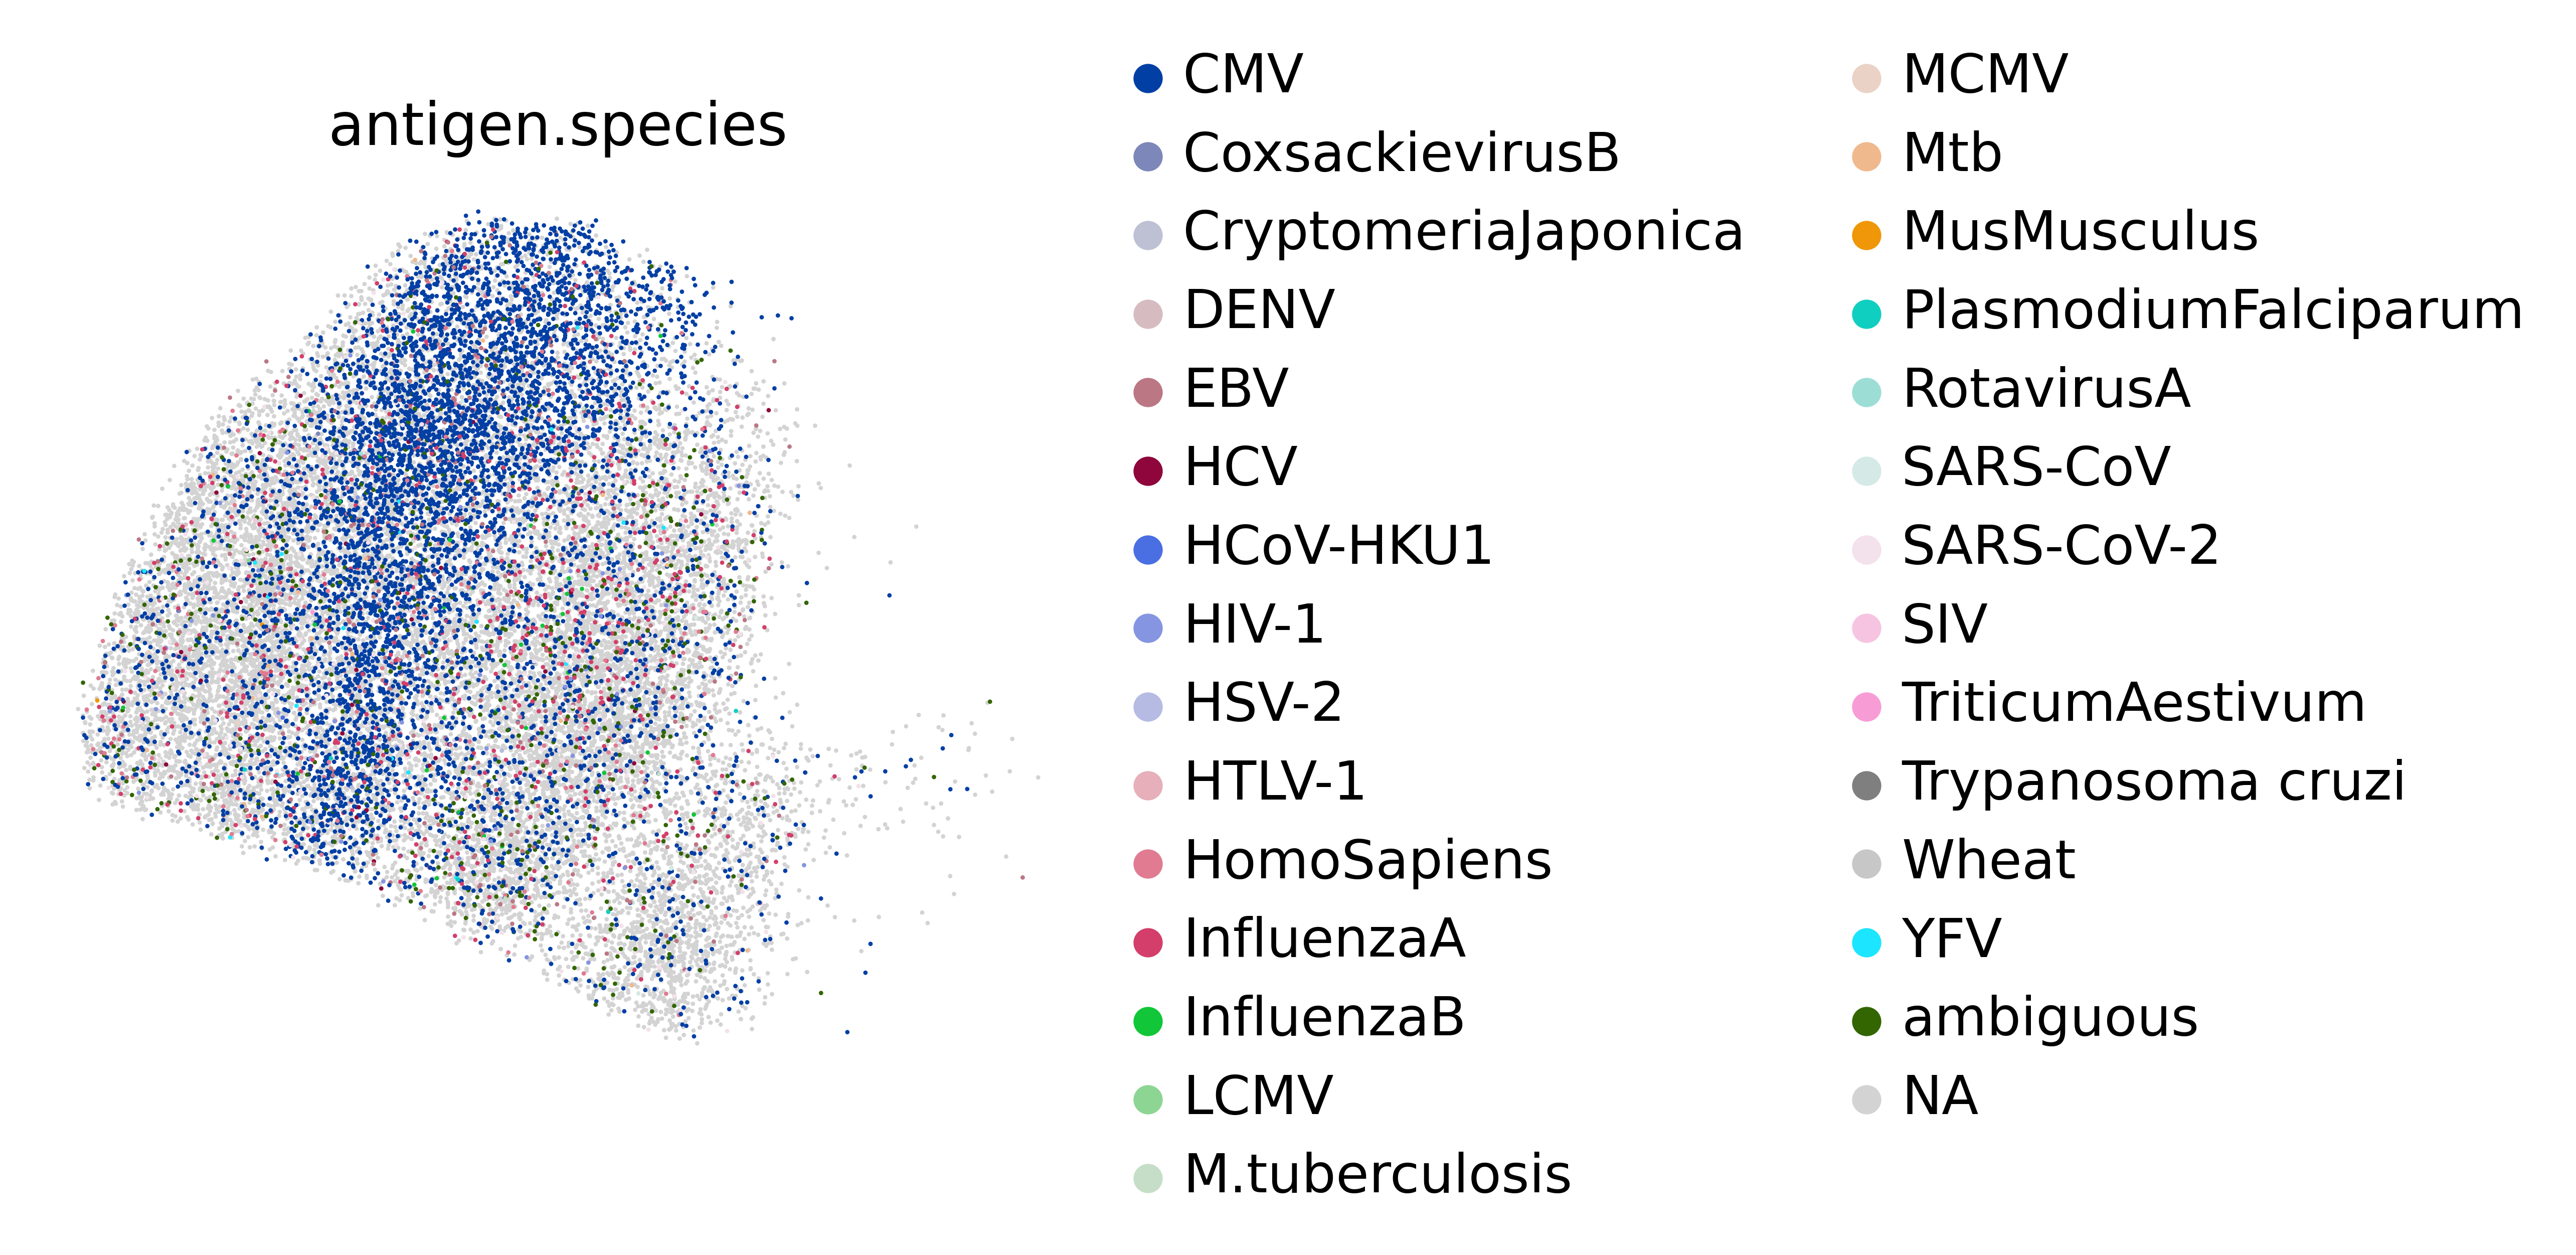

In [ ]:
ir.pl.embedding(adata_tcr, color='antigen.species', frameon=False, basis='X_umap', save='_scTCR_vdjdb.pdf', show=True)

In [298]:
df_net['antigen.species'].value_counts()

antigen.species
CMV                     1116
InfluenzaA                95
EBV                       29
ambiguous                 12
HomoSapiens               10
InfluenzaB                 8
SARS-CoV-2                 5
YFV                        1
DENV                       0
CryptomeriaJaponica        0
CoxsackievirusB            0
HCV                        0
HSV-2                      0
HTLV-1                     0
HCoV-HKU1                  0
HIV-1                      0
Mtb                        0
LCMV                       0
M.tuberculosis             0
MCMV                       0
RotavirusA                 0
PlasmodiumFalciparum       0
MusMusculus                0
SARS-CoV                   0
TriticumAestivum           0
SIV                        0
Wheat                      0
Trypanosoma cruzi          0
Name: count, dtype: int64

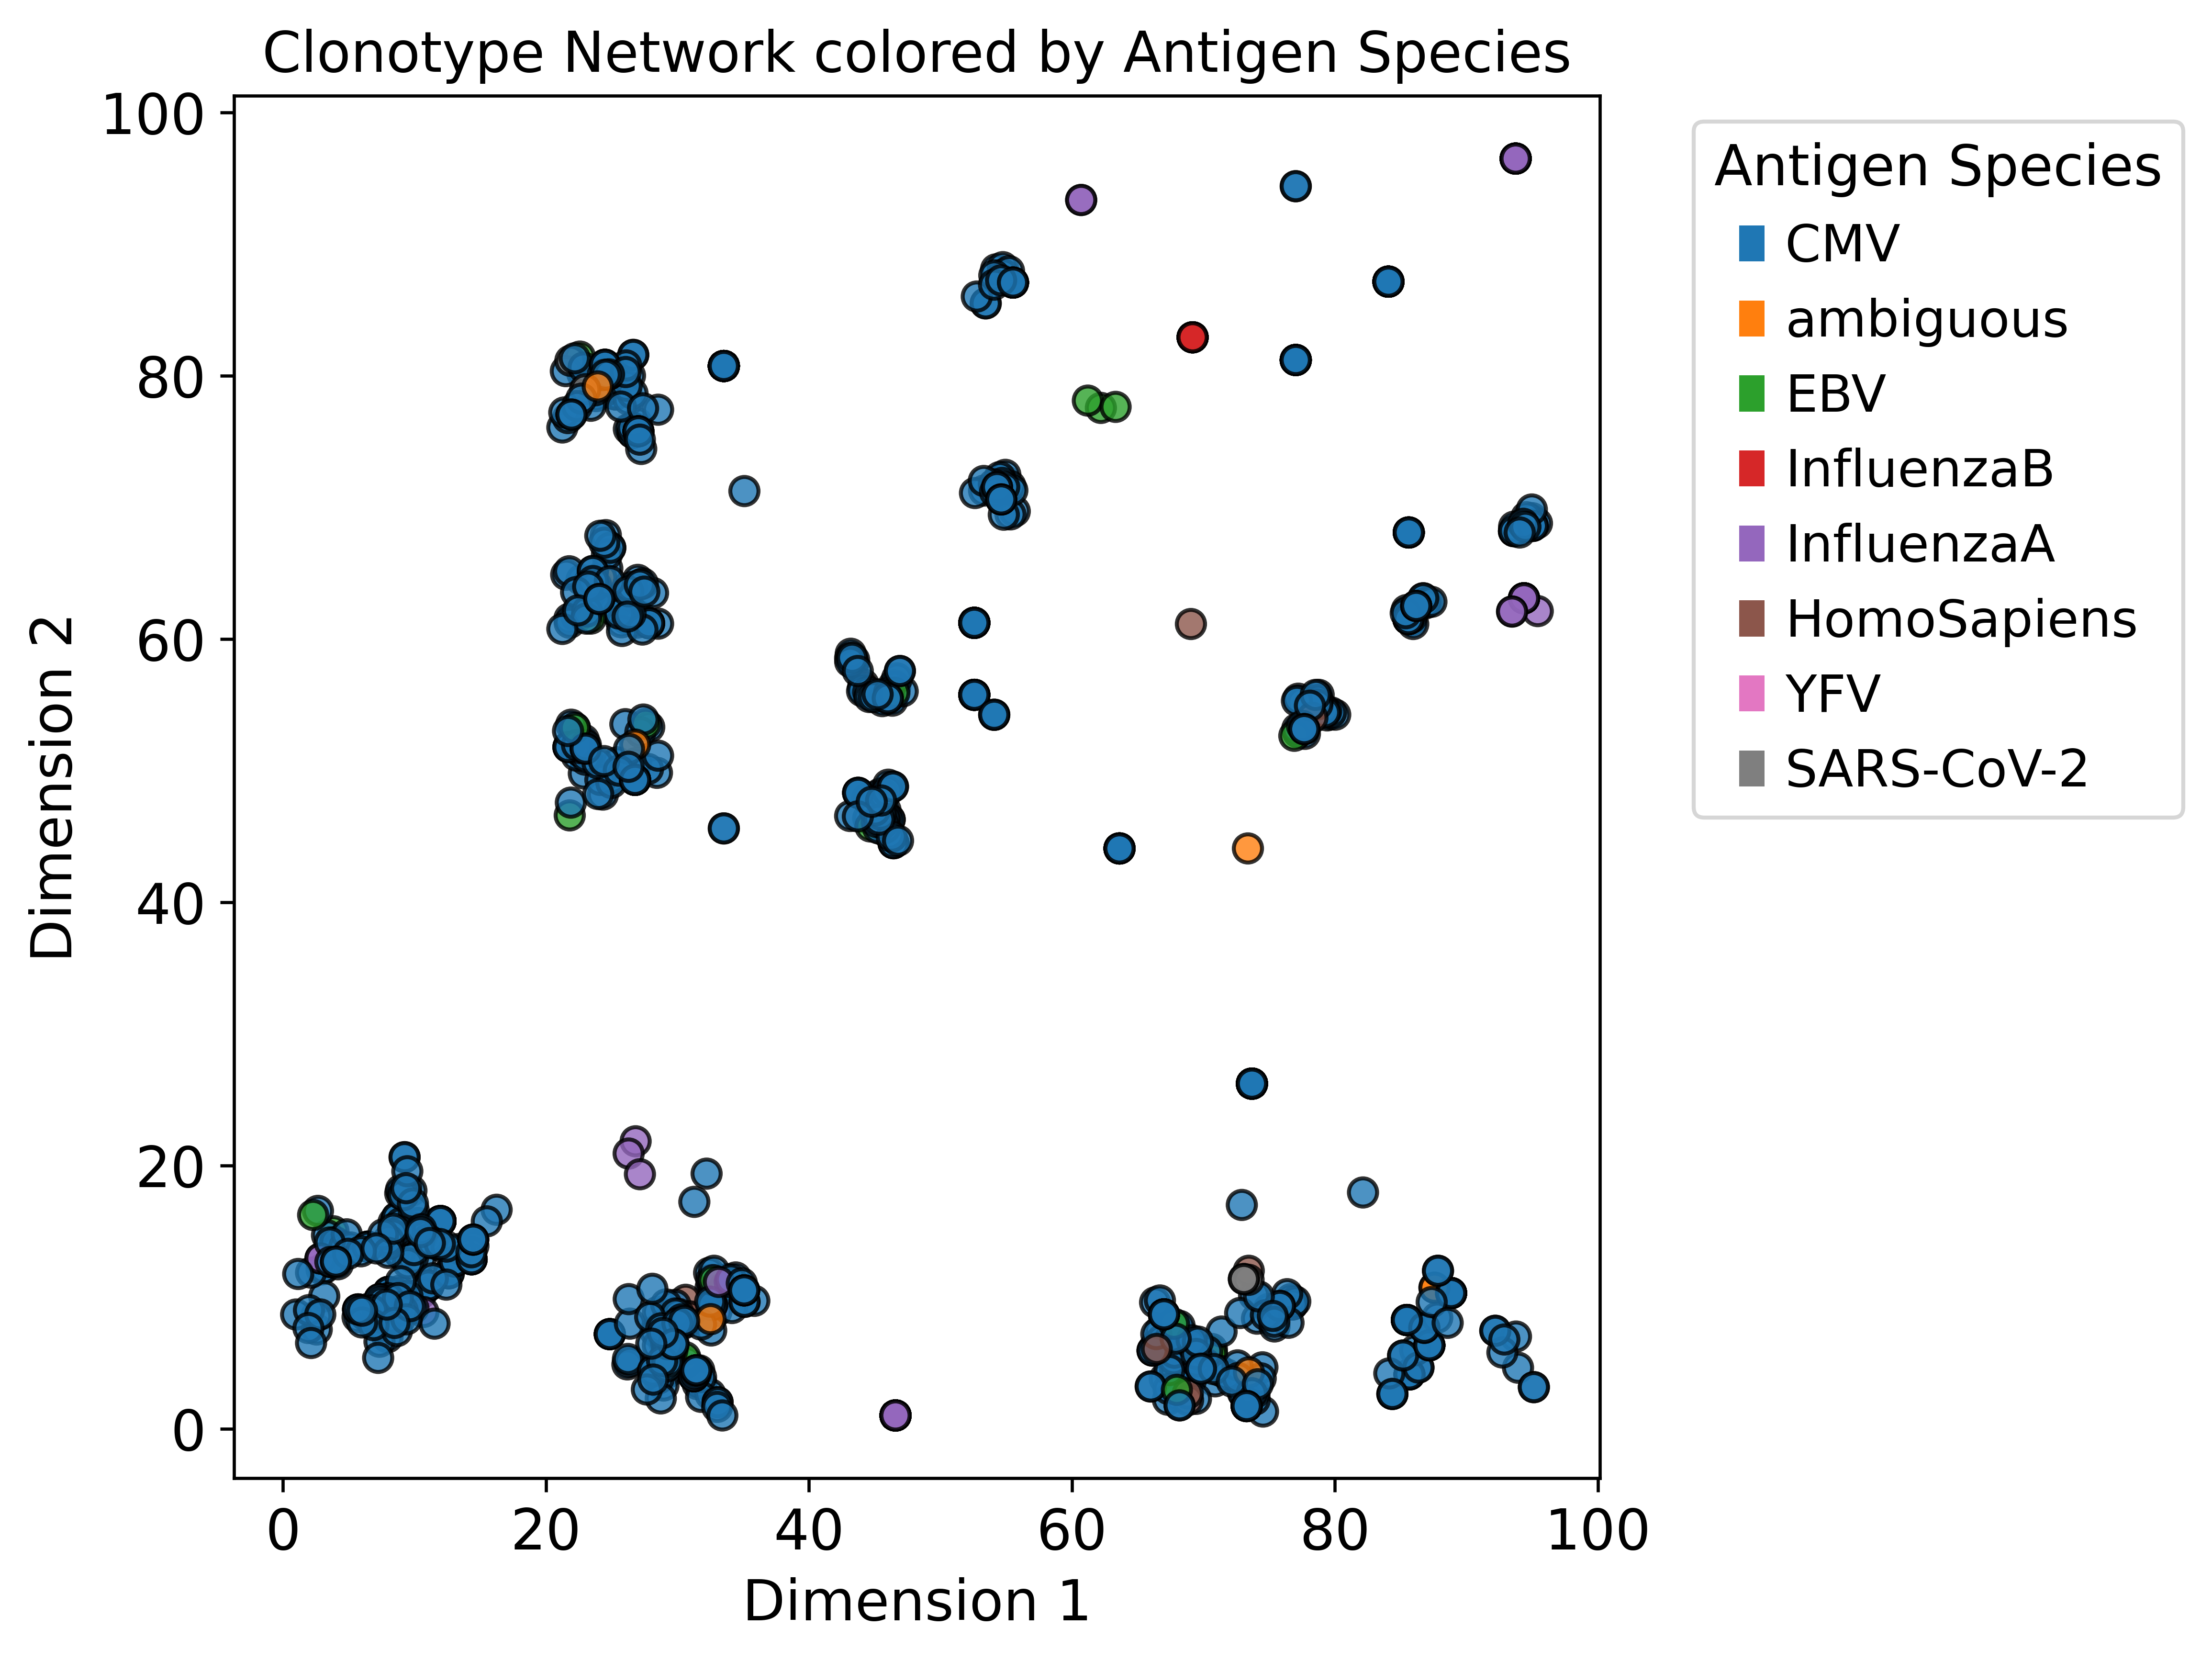

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 选取数据
df_net = adata_tcr.obsm['X_clonotype_network'][(adata_tcr.obs['cell_type_lvl2'] == 'MAIT')].dropna()
df_net['antigen.species'] = adata_tcr.obs['antigen.species'][(adata_tcr.obs['cell_type_lvl2'] == 'MAIT')].dropna()

# 建立一个颜色映射
df_net = df_net.dropna(subset=['antigen.species'])
# 转为字符串类型再映射
df_net['antigen.species'] = df_net['antigen.species'].astype(str)

# 构造颜色映射
species_list = df_net['antigen.species'].unique()
palette = dict(zip(species_list, sns.color_palette("hsv", len(species_list))))
colors = df_net['antigen.species'].map(palette)

species_list = df_net['antigen.species'].unique()

palette = dict(zip(species_list, sns.color_palette("tab10", len(species_list))))

# 根据 antigen.species 映射颜色

colors = df_net['antigen.species'].map(palette)

# 绘制 scatter
plt.figure(figsize=(8, 6))
plt.scatter(
    df_net.iloc[:, 0], df_net.iloc[:, 1], 
    c=colors, edgecolors='k', s=50, alpha=0.8
)

# legend 手动加上
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(facecolor=palette[sp], label=sp) for sp in species_list]
plt.legend(handles=legend_elements, title="Antigen Species", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Clonotype Network colored by Antigen Species')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(False)
plt.tight_layout()
#plt.show()
plt.savefig('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/Clonotype_Network_sampleshared_MAIT_colored_by_Antigen_Species.pdf', bbox_inches='tight')

In [39]:
pd.crosstab(adata_tcr.obs['cell_type_lvl2'], adata_tcr.obs['antigen.species'])

antigen.species        CMV  CoxsackievirusB  CryptomeriaJaponica  DENV  EBV  \
cell_type_lvl2                                                                
Circulating NKT cell   184                0                    0     0   21   
MAIT                  4618                1                    1     0  179   
Teff_CD8              1037                0                    0     0  117   
Tnaive_CD4/CD8         411                1                    0     1   35   
Treg                   105                0                    0     0   15   

antigen.species       HCV  HCoV-HKU1  HIV-1  HSV-2  HTLV-1  ...  \
cell_type_lvl2                                              ...   
Circulating NKT cell    0          0      3      0       0  ...   
MAIT                   22          0     13      2       0  ...   
Teff_CD8               12          0     28      1       0  ...   
Tnaive_CD4/CD8         10          1     11      0       1  ...   
Treg                    2          0      5      1       0  ...   

antigen.species       PlasmodiumFalciparum  RotavirusA  SARS-CoV  SARS-CoV-2  \
cell_type_lvl2                                                                 
Circulating NKT cell                     1           0         2          23   
MAIT                                     2           1         1          85   
Teff_CD8                                 2           0         1          66   
Tnaive_CD4/CD8                           0           0         0          45   
Treg                                     0           0         1          13   

antigen.species       SIV  TriticumAestivum  Trypanosoma cruzi  Wheat  YFV  \
cell_type_lvl2                                                               
Circulating NKT cell    0                 0                  0      0    0   
MAIT                    0                 1                  0      1   11   
Teff_CD8                0                 0                  0      0    4   
Tnaive_CD4/CD8          1                 1                  1      0    4   
Treg                    0                 0                  0      1    1   

antigen.species       ambiguous  
cell_type_lvl2                   
Circulating NKT cell         56  
MAIT                        226  
Teff_CD8                    277  
Tnaive_CD4/CD8              101  
Treg                         23  

[5 rows x 28 columns]

In [142]:
# Clonal expansion analysis
ir.tl.clonal_expansion(adata_tcr, breakpoints=[1, 10])
adata_tcr.obs['clone_status'] = adata_tcr.obs['clonal_expansion'].replace({'<= 1': '1', '<= 10': '2', '> 10': '≥3'})
adata_tcr.obs['clone_status'] = adata_tcr.obs['clone_status'].cat.remove_categories(['nan'])

/tmp/ipykernel_86990/1310460409.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_tcr.obs['clone_status'] = adata_tcr.obs['clonal_expansion'].replace({'<= 1': '1', '<= 10': '2', '> 10': '≥3'})


In [ ]:
# Evaluate differences of clonal state between disease status iin each cluster [Minor Revision]
# The average clonal expansion rate of each sample was evaluated using two-sided Welch's t-test, where only cells mapped with TCRs were included in the analysis.
adata_tcr.obs['clone_status'] = ['Clonal' if size >1 else 'No clonal' for size in adata_tcr.obs['clone_id_size']]
clonal_cells = adata_tcr[adata_tcr.obs['clone_status'] == 'Clonal'].obs_names
no_clonal_cells = adata_tcr[adata_tcr.obs['clone_status'] == 'No clonal'].obs_names

adata_tcr_pre = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_prescirpy_29samples.h5ad')
adata_tcr_pre = adata_tcr_pre[~adata_tcr_pre.obs['cell_type_lvl2'].isin(['Resident NK cell', 'Circulating NK cell'])]
adata_tcr_pre = adata_tcr_pre[adata_tcr_pre.obs['Centrifugation'].isin(['NPC'])]
adata_tcr_pre.obs['clone_status'] = 'Non-VDJ'
adata_tcr_pre.obs.loc[adata_tcr_pre.obs_names.isin(intersect_obs_names), 'clone_status'] = 'No clonal'
adata_tcr_pre.obs.loc[adata_tcr_pre.obs_names.isin(clonal_cells), 'clone_status'] = 'Clonal'


/tmp/ipykernel_86990/3279944302.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_tcr_pre.obs['clone_status'] = 'Non-VDJ'


# scBCR Analysis

In [ ]:
adata_bcr = adata_gex[adata_gex.obs.cell_type_lvl1.isin(['B cell', 'Plasma cell'])].copy()
adata_bcr.X = adata_bcr.layers['counts'].copy()

import harmonypy
import scanpy.external as sce
# Normalization
sc.pp.normalize_total(adata_bcr)
sc.pp.log1p(adata_bcr)

# Batch effect Correction
sc.pp.highly_variable_genes(adata_bcr, n_top_genes=3000, batch_key="sample", flavor='seurat_v3')
adata_bcr.var.loc[(adata_bcr.var.index.str.startswith('IGLV')) | (adata_bcr.var.index.str.startswith('IGKV')) | (adata_bcr.var.index.str.startswith('IGHV')) | (adata_bcr.var.index.str.startswith('IGLC')) | (adata_bcr.var.index.str.startswith('IGKC')) | (adata_bcr.var.index.str.startswith('IGHG')) | (adata_bcr.var.index.str.startswith('IGHA')), 'highly_variable'] = False
sc.pp.pca(adata_bcr)
sce.pp.harmony_integrate(adata_bcr, 'orig.ident', max_iter_harmony=30)
sc.pp.neighbors(adata_bcr, n_neighbors=30, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata_bcr)
sc.tl.leiden(adata_bcr, resolution=1.0, flavor='igraph', n_iterations=2)

In [ ]:
sc.tl.rank_genes_groups(adata_tcr, groupby='leiden', method='wilcoxon', n_genes=10, tie_correct=True, groups=['5'], reference='11')
sc.get.rank_genes_groups_df(adata_tcr, group='5')

In [ ]:
sc.tl.rank_genes_groups(adata_bcr, groupby='leiden', method='wilcoxon', n_genes=10, tie_correct=True, groups=['11'], reference='2')
sc.get.rank_genes_groups_df(adata_bcr, group='11')

In [156]:
adata_bcr

View of AnnData object with n_obs × n_vars = 17576 × 34744
    obs: 'sample', 'disease_status', 'Centrifugation', 'orig.ident', 'Age', 'Sex', 'Steatosis', 'Ballooning', 'Lobular_inflammation', 'Fibrosis', 'NAS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_R', 'cell_type_lvl1', 'cell_type_lvl2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_lvl1_colors', 'cell_type_lvl2_colors', 'disease_status_colors', 'hvg', 'leiden', 'leiden_R', 'leiden_R_colors', 'log1p', 'neighbors', 'pca', 'sam

In [ ]:
# Minor Revision
adata_bcr = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_bcr_prescirpy.h5ad')
adata_bcr.obs['disease_status'] = adata_bcr.obs['disease_status'].cat.rename_categories({'MASLD': 'MASL'})
adata_bcr.obs['disease_status'] = adata_bcr.obs['disease_status'].cat.reorder_categories(['CTRL', 'MASL', 'MASH'], ordered=True)
adata_bcr = adata_bcr[(adata_bcr.obs['sample'] != 'CTRL-184') & (adata_bcr.obs['n_genes_by_counts'] < 6000)  & (adata_bcr.obs['total_counts'] < 40000)] # 18011 -> 17576
# Revise clinical information
adata_bcr.obs.loc[adata_bcr.obs['sample'] == 'CTRL-5759', 'Age'] = 34
adata_bcr.obs.loc[adata_bcr.obs['sample'] == 'CTRL-5759', 'NAS'] = 0

In [ ]:
#adata_bcr.write('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_bcr_prescirpy_29samples.h5ad')
adata_bcr = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_bcr_prescirpy_29samples.h5ad')

In [ ]:
#sc.pl.umap(adata_bcr, color=['leiden'], legend_loc='on data', frameon=False)
sc.pl.umap(adata_bcr, color=['MS4A1', 'CD79A', 'TCL1A', 'IGHD', 'IGHM', 'IGHG1', 'IGHG2','IGHA1', 'IGHA2', 'TNFRSF13B'], legend_loc='on data', frameon=False, save='B_markers', cmap='RdBu_r', ncols=5)

In [ ]:
adata_bcr.obs["cell_type_lvl2"] = adata_bcr.obs["leiden"].map(
    {
        "0": "Plasma_IgG",
        "1": "Plasma_IgA",
        "2": "Plasma_IgA",
        "3": "Bmemory",
        "4": "Bnaive",
        "5": "Bmemory",
        "6": "Bnaive",
        "7": "Plasma_IgG",
        "8": "Bnaive",
        "9": "Bnaive",

    }
)

cell_type_lvl2_palette={
    "Bnaive": "#7cb6de",
    'Bmemory': '#DDEFFF',
    "Plasma_IgG": "#F4C4F4",
    'Plasma_IgA' : '#4E79A7',
}
sc.pl.umap(adata_bcr, color=['cell_type_lvl2'], legend_loc='on data', frameon=False, legend_fontsize=5, palette=cell_type_lvl2_palette, save='_B.pdf', title='')

In [ ]:
# Create a list of AnnData objects (one for each sample)
samples = adata_bcr.obs['sample'].unique()
adatas_airr = {}
for sample in samples:
    adata_airr = ir.io.read_airr(f'/data/project/AI4Omic/MASLD/data/scVDJ/{sample}-B_airr_rearrangement.tsv')
    # Add sample name for prefixing the obs names
    adata_airr.obs_names = sample + '_' + adata_airr.obs_names
    adatas_airr[sample] = adata_airr

# Concatenate all AnnData objects into one
adata_airr = anndata.concat(adatas_airr, index_unique=None)

In [176]:
# Work without MuData
# Map each cell barcode to its respective numeric index (assumes obs_names are unique)
barcode2idx = {barcode: i for i, barcode in enumerate(adata_airr.obs_names)}
# Generate a slice for the awkward array that retrieves the corresponding row
# from `adata_airr` for each barcode in `adata_gex`. `-1` will generate all
# "None"s for barcodes that are not in `adata_airr`
idx = [barcode2idx.get(barcode, -1) for barcode in adata_bcr.obs_names]
adata_bcr.obsm["airr"] = adata_airr.obsm["airr"][idx]

/tmp/ipykernel_86990/965574971.py:8: ImplicitModificationWarning: Setting element `.obsm['airr']` of view, initializing view as actual.
  adata_bcr.obsm["airr"] = adata_airr.obsm["airr"][idx]


In [177]:
ir.pp.index_chains(adata_bcr, filter=['productive', "require_junction_aa"])
ir.tl.chain_qc(adata_bcr)

In [178]:
# Remove multi_chain Barcode
#adata = adata_bcr[adata_bcr.obs["multi_chain"] != "True", :].copy()    
#print("Number of Cell after remove multi_chain:{:.2f}".format(adata.n_obs))
# Remove all cells that don’t have at least one full pair of receptor sequences
adata_bcr = adata_bcr[~adata_bcr.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ", "ambiguous","no IR"]), :].copy()
print("Number of Cell after remove orpha_chain:{:.2f}".format(adata_bcr.n_obs))                    

print("data shape after filtering")
print(adata_bcr.shape)

#------------------------------------------------#
#    Define clonotypes and clonotype clusters    #
#------------------------------------------------#

#----- Construct a neighborhood graph based on CDR3 nucleotide sequency similariy ----#

ir.pp.ir_dist(adata_bcr)     # computes sequence-distance metric btw all unique CDR3
                         # default: using identity (not alighment), sequecen: nucleotide

# detect connected modules in the graph and annotate them as clonotypes
ir.tl.define_clonotypes(adata_bcr, receptor_arms="all", dual_ir="primary_only", n_jobs=20)

#----- Recompute CDR3 neighborhood graph and difine clonotype clusters -----#
ir.pp.ir_dist(
        adata_bcr, 
        metric = "alignment",
        sequence = "aa",
        cutoff = 2,
        n_jobs=10
        )

ir.tl.define_clonotype_clusters(
       adata_bcr, sequence = "aa", metric = "alignment", receptor_arms="all", dual_ir="any", n_jobs=20
       )

ir.tl.clonotype_network(adata_bcr, min_cells = 5, sequence = "aa", metric = "alignment")

# Clonal expansion analysis
#ir.tl.clonal_expansion(adata_bcr, breakpoints=[1, 2])
#adata_bcr.obs['clonal_expansion'] = adata_bcr.obs['clonal_expansion'].replace({'<= 1': '1', '<= 2': '2', '> 2': '≥3'})
#adata_bcr.obs['clonal_expansion'] = adata_bcr.obs['clonal_expansion'].cat.remove_categories(['nan'])

Number of Cell after remove orpha_chain:6192.00
data shape after filtering
(6192, 34744)


100%|██████████| 528/528 [00:02<00:00, 216.82it/s]


In [100]:
sns.color_palette("Set1", 20)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(wspace=0.05)
adata_bcr.obs.disease_status = adata_bcr.obs['disease_status'].cat.reorder_categories(['CTRL', 'MASL', 'MASH'])
# Generate a palette with 30 discrete colors
palette = sns.color_palette("tab20", 20) + ['#F4A460', '#F4B264', '#F4C26E', "#DA80DA", "#815481", "#C040C0", "#E1AFE1", "#3F0034", "#EDABB9", "#EB5C79", "#A06A75", "#C00028"]

ir.pl.clonotype_network(adata_bcr, color="sample", base_size=60, label_fontsize=9, panel_size=(7, 6), show_legend=False, show_labels=False, palette=palette, title='Sample', ax=ax[0], show_size_legend=True, legend_width=6)
ir.pl.clonotype_network(adata_bcr, color="disease_status", base_size=60, label_fontsize=9, panel_size=(7, 6), show_labels=False, title='Disease status', ax=ax[1], show_size_legend=True, legend_width=6)
ir.pl.clonotype_network(adata_bcr, color="cell_type_lvl2", base_size=60, label_fontsize=9, panel_size=(7, 6), show_labels=False, palette=cell_type_lvl2_palette, title='Cell type', ax=ax[2], legend_width=6)
plt.tight_layout()
plt.savefig('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/scBCR_clonotype_network.pdf')

In [ ]:
adata_bcr.obs['clonal_expansion'] = adata_bcr.obs['clonal_expansion'].cat.remove_categories(['nan'])

In [179]:
adata_bcr

AnnData object with n_obs × n_vars = 6192 × 34744
    obs: 'sample', 'disease_status', 'Centrifugation', 'orig.ident', 'Age', 'Sex', 'Steatosis', 'Ballooning', 'Lobular_inflammation', 'Fibrosis', 'NAS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_R', 'cell_type_lvl1', 'cell_type_lvl2', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'cc_aa_alignment', 'cc_aa_alignment_size'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_lvl1_colors', 'cell_type_lvl

In [ ]:
ir.tl.clonal_expansion(adata_bcr, breakpoints=[1, 2])
ir.pl.group_abundance(
    adata_bcr,
    target_col="cell_type_lvl2",
    groupby="clonal_expansion",
    sort=["<= 1", "<= 2", "> 2"],
    normalize=True,
)
plt.ylabel("")
plt.title("")
plt.tight_layout()
plt.savefig('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/scBCR_clonalexpansion_celltypelvl2.pdf')

In [ ]:
sc.pl.umap(adata_bcr, color=['clone_id_size'], s=10, frameon=False)
sc.pl.umap(adata_bcr, color=['clonal_expansion'], s=10, frameon=False, palette=['#DDEFFF', '#F4C4F4', '#601C00'])

In [ ]:
adata_bcr = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_bcr_postscirpy_29samples.h5ad')
#adata_bcr.write('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_bcr_postscirpy_29samples.h5ad')